In [4]:
import tensorflow as tf

# import os
import math
import numpy as np

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

In [5]:
from ipynb.fs.full.dataset import *
from ipynb.fs.full.moduel import *

In [6]:
train_dir = "./dataset/train"
test_dir = "./dataset/test"
test_img_paths = test_imgs(test_dir)
train_ds, valid_ds = setup_dataset(train_dir)
train_ds, valid_ds = dataset_preprocessing(train_ds,valid_ds)

Found 21520 files belonging to 1 classes.
Using 17216 files for training.
Found 21520 files belonging to 1 classes.
Using 4304 files for validation.
Cause: could not parse the source code of <function dataset_preprocessing.<locals>.<lambda> at 0x7fbf226218b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function dataset_preprocessing.<locals>.<lambda> at 0x7fbf226218b0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function dataset_preprocessing.<locals>.<lambda> at 0x7fbf33539dc0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function dataset_preprocessing.<locals>.<lambda> at 0x7fbf33539dc0>

In [7]:
# def plot_results(img, prefix, title):
#     """Plot the result with zoom-in area."""
#     img_array = img_to_array(img)
#     img_array = img_array.astype("float32") / 255.0

#     # Create a new figure with a default 111 subplot.
#     fig, ax = plt.subplots()
#     im = ax.imshow(img_array[::-1], origin="lower")

#     plt.title(title)
#     # zoom-factor: 3, location: upper-left
#     axins = zoomed_inset_axes(ax, 4, loc=3)
#     axins.imshow(img_array[::-1], origin="lower")

#     # Specify the limits.
#     x1, x2, y1, y2 = 75, 160, 165, 180
#     # Apply the x-limits.
#     axins.set_xlim(x1, x2)
#     # Apply the y-limits.
#     axins.set_ylim(y1, y2)

#     plt.yticks(visible=False)
#     plt.xticks(visible=False)

#     # Make the line.
#     mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="blue")
# #     plt.savefig(str(prefix) + "-" + title + ".png")
#     plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [8]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
#         if epoch % 20 == 0:
#             prediction = upscale_image(self.model, self.test_img)
#             plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [9]:
# Stop training when a monitored metric has stopped improving.
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./model_weights/ckpt"

# save a model or weights (in a checkpoint file) at some interval, 
# so the model or weights can be loaded later to continue the 
# training from the state saved.

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

IndentationError: unexpected indent (1061125947.py, line 4)

Epoch 1/100


2022-10-19 08:53:44.508892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Mean PSNR for epoch: 30.75
1/1 [==============================] - 0s 154ms/step


/tmp/ipykernel_103497/1297474122.py:56: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
/tmp/ipykernel_103497/1297474122.py:57: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)


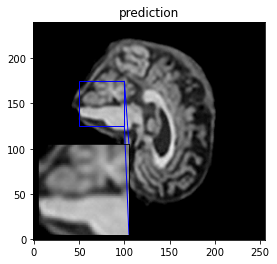

2152/2152 - 33s - loss: 0.0015 - val_loss: 8.3840e-04 - 33s/epoch - 15ms/step
Epoch 2/100
Mean PSNR for epoch: 31.02
2152/2152 - 30s - loss: 8.2385e-04 - val_loss: 7.8881e-04 - 30s/epoch - 14ms/step
Epoch 3/100
Mean PSNR for epoch: 31.15
2152/2152 - 31s - loss: 7.7850e-04 - val_loss: 7.6446e-04 - 31s/epoch - 14ms/step
Epoch 4/100
Mean PSNR for epoch: 31.33
2152/2152 - 31s - loss: 7.5071e-04 - val_loss: 7.3279e-04 - 31s/epoch - 14ms/step
Epoch 5/100
Mean PSNR for epoch: 31.43
2152/2152 - 31s - loss: 7.2999e-04 - val_loss: 7.1794e-04 - 31s/epoch - 14ms/step
Epoch 6/100
Mean PSNR for epoch: 31.51
2152/2152 - 29s - loss: 7.1465e-04 - val_loss: 7.0491e-04 - 29s/epoch - 14ms/step
Epoch 7/100
Mean PSNR for epoch: 31.58
2152/2152 - 30s - loss: 7.0175e-04 - val_loss: 6.9438e-04 - 30s/epoch - 14ms/step
Epoch 8/100
Mean PSNR for epoch: 31.59
2152/2152 - 30s - loss: 6.9217e-04 - val_loss: 6.9120e-04 - 30s/epoch - 14ms/step
Epoch 9/100
Mean PSNR for epoch: 31.68
2152/2152 - 30s - loss: 6.8336e-04 -

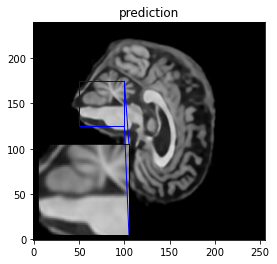

2152/2152 - 31s - loss: 6.3990e-04 - val_loss: 6.4432e-04 - 31s/epoch - 14ms/step
Epoch 22/100
Mean PSNR for epoch: 31.93
2152/2152 - 31s - loss: 6.3842e-04 - val_loss: 6.4038e-04 - 31s/epoch - 14ms/step
Epoch 23/100
Mean PSNR for epoch: 31.91
2152/2152 - 31s - loss: 6.3671e-04 - val_loss: 6.4244e-04 - 31s/epoch - 14ms/step
Epoch 24/100
Mean PSNR for epoch: 31.93
2152/2152 - 30s - loss: 6.3529e-04 - val_loss: 6.4027e-04 - 30s/epoch - 14ms/step
Epoch 25/100
Mean PSNR for epoch: 31.96
2152/2152 - 31s - loss: 6.3378e-04 - val_loss: 6.3694e-04 - 31s/epoch - 14ms/step
Epoch 26/100
Mean PSNR for epoch: 31.97
2152/2152 - 31s - loss: 6.3286e-04 - val_loss: 6.3517e-04 - 31s/epoch - 14ms/step
Epoch 27/100
Mean PSNR for epoch: 31.95
2152/2152 - 31s - loss: 6.3164e-04 - val_loss: 6.3637e-04 - 31s/epoch - 14ms/step
Epoch 28/100
Mean PSNR for epoch: 31.95
2152/2152 - 31s - loss: 6.2991e-04 - val_loss: 6.3621e-04 - 31s/epoch - 14ms/step
Epoch 29/100
Mean PSNR for epoch: 31.98
2152/2152 - 30s - loss: 

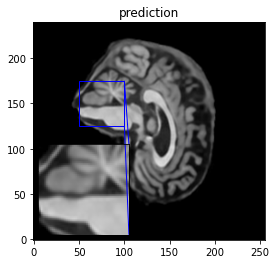

2152/2152 - 30s - loss: 6.1846e-04 - val_loss: 6.2765e-04 - 30s/epoch - 14ms/step
Epoch 42/100
Mean PSNR for epoch: 32.03
2152/2152 - 30s - loss: 6.1771e-04 - val_loss: 6.2635e-04 - 30s/epoch - 14ms/step
Epoch 43/100
Mean PSNR for epoch: 32.00
2152/2152 - 30s - loss: 6.1747e-04 - val_loss: 6.2961e-04 - 30s/epoch - 14ms/step
Epoch 44/100
Mean PSNR for epoch: 32.04
2152/2152 - 31s - loss: 6.1648e-04 - val_loss: 6.2482e-04 - 31s/epoch - 14ms/step
Epoch 45/100
Mean PSNR for epoch: 31.98
2152/2152 - 31s - loss: 6.1598e-04 - val_loss: 6.3284e-04 - 31s/epoch - 14ms/step
Epoch 46/100
Mean PSNR for epoch: 32.03
2152/2152 - 32s - loss: 6.1551e-04 - val_loss: 6.2538e-04 - 32s/epoch - 15ms/step
Epoch 47/100
Mean PSNR for epoch: 32.05
2152/2152 - 30s - loss: 6.1505e-04 - val_loss: 6.2350e-04 - 30s/epoch - 14ms/step
Epoch 48/100
Mean PSNR for epoch: 32.03
2152/2152 - 30s - loss: 6.1421e-04 - val_loss: 6.2580e-04 - 30s/epoch - 14ms/step
Epoch 49/100
Mean PSNR for epoch: 32.01
2152/2152 - 30s - loss: 

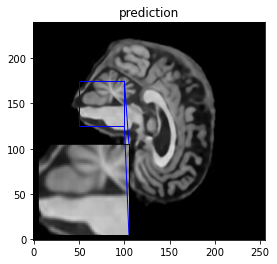

2152/2152 - 31s - loss: 6.0882e-04 - val_loss: 6.2302e-04 - 31s/epoch - 14ms/step
Epoch 62/100
Mean PSNR for epoch: 32.05
2152/2152 - 30s - loss: 6.0833e-04 - val_loss: 6.2258e-04 - 30s/epoch - 14ms/step
Epoch 63/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 6.0787e-04 - val_loss: 6.2268e-04 - 30s/epoch - 14ms/step
Epoch 64/100
Mean PSNR for epoch: 32.05
2152/2152 - 30s - loss: 6.0763e-04 - val_loss: 6.2202e-04 - 30s/epoch - 14ms/step
Epoch 65/100
Mean PSNR for epoch: 32.07
2152/2152 - 30s - loss: 6.0728e-04 - val_loss: 6.2015e-04 - 30s/epoch - 14ms/step
Epoch 66/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 6.0714e-04 - val_loss: 6.2176e-04 - 30s/epoch - 14ms/step
Epoch 67/100
Mean PSNR for epoch: 32.04
2152/2152 - 30s - loss: 6.0678e-04 - val_loss: 6.2366e-04 - 30s/epoch - 14ms/step
Epoch 68/100
Mean PSNR for epoch: 32.07
2152/2152 - 30s - loss: 6.0626e-04 - val_loss: 6.2014e-04 - 30s/epoch - 14ms/step
Epoch 69/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 

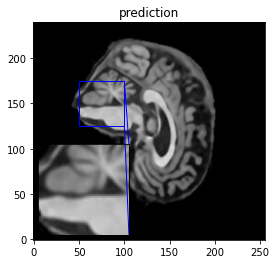

2152/2152 - 30s - loss: 6.0279e-04 - val_loss: 6.2167e-04 - 30s/epoch - 14ms/step
Epoch 82/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 6.0259e-04 - val_loss: 6.2167e-04 - 30s/epoch - 14ms/step
Epoch 83/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 6.0228e-04 - val_loss: 6.2062e-04 - 30s/epoch - 14ms/step
Epoch 84/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 6.0219e-04 - val_loss: 6.2103e-04 - 30s/epoch - 14ms/step
Epoch 85/100
Mean PSNR for epoch: 32.06
2152/2152 - 31s - loss: 6.0173e-04 - val_loss: 6.2114e-04 - 31s/epoch - 15ms/step
Epoch 86/100
Mean PSNR for epoch: 32.09
2152/2152 - 30s - loss: 6.0200e-04 - val_loss: 6.1786e-04 - 30s/epoch - 14ms/step
Epoch 87/100
Mean PSNR for epoch: 32.05
2152/2152 - 30s - loss: 6.0130e-04 - val_loss: 6.2287e-04 - 30s/epoch - 14ms/step
Epoch 88/100
Mean PSNR for epoch: 32.04
2152/2152 - 31s - loss: 6.0128e-04 - val_loss: 6.2491e-04 - 31s/epoch - 15ms/step
Epoch 89/100
Mean PSNR for epoch: 32.06
2152/2152 - 30s - loss: 

In [7]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)